In [1]:
# Load the required Python libraries

import os
import cftime
import ipywidgets as widgets
import glob
import numpy as np

In [2]:
# Create case run output directories

#output_rootdir=os.path.expanduser('~')+'/output/cime_run_dirs/'
output_rootdir='/output/cime_run_dirs/'
cases=np.asarray(glob.glob("%s*20TR*" % output_rootdir))
cases=[x.split('/')[-1] for x in cases]
cases_dropdown = widgets.Dropdown(options=cases,
                                description='Chose Case Name:',
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                disabled=False)

In [3]:
# Show a dropdown menu to select specific case output
# Any cases that have been run in our elmoutput directory will be displayed
# Case names will contain the site codes:
# AK-BEO; AK-CLG; AK-K64G AK-TLG

display(cases_dropdown)

Dropdown(description='Chose Case Name:', layout=Layout(width='max-content'), options=('topounit_gswp3_AK-SP-CL…

In [4]:
# Get the output nc file options

output_casedir=output_rootdir+cases_dropdown.value+'/run/'
# merged subgrid output nc files
filenames=np.asarray(glob.glob("%s*_subgrid.out*.nc" % output_casedir))
filenames=sorted([x.split('/')[-1] for x in filenames])
if(os.path.exists(output_casedir+'ELM_output.nc')): filenames.insert(0,'ELM_output.nc')

ncfiles_dropdown = widgets.Dropdown(options=filenames,
                                description='Choose Output File:', 
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                disabled=False)

In [5]:
# Display the output nc file options - in most cases you will select ELM_output.nc

display(ncfiles_dropdown)

Dropdown(description='Choose Output File:', layout=Layout(width='max-content'), options=('ELM_output.nc', 'Mas…

In [6]:
# Set the output

output_file=output_casedir+ncfiles_dropdown.value

In [7]:
## Subgrid analysis for NGEE Arctic MODEX workshop
# first shared: January 6, 2026
# by Nick Bruns, (nicholas.e.bruns@gmail.com)

## 2 notes:
    # 1) CAPS indicate globals that I use in functions
        # e.g this surface file
            # DS_SURF_FILE = xr.open_dataset(surf_file_dirname + surf_file_filename)
    # 2) I do unit conversions right after I extract subgrid columns
        # think if this confused future analyses, and if this should be only applied at the plot level


#%% 1. imports and constants
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# run constants 
CUR_MEAN_DURATION = slice("2005","2014")

##dirs
surf_file_dirname = "/inputdata/E3SM/lnd/clm2/surfdata_map/"
FULL_HIST_DIRNAME = "/output/cime_run_dirs/topounit_gswp3_AK-SP-CL71_ICB20TRCNPRDCTCBC/run/"
# note: capitalizwd because used in function, get_and_aggregate_hist_ds

# filenames
surf_file_filename =  "topounit_surfdata_0.5x0.5_simyr1850_c20220204_C71-GRID.nc"

DICT_FILE_NAMES = {
    "IM0_DS0": "MasterE3SM_subgrid.out_met-ds-NO_IM-2-NO_yes.topounit_gswp3_AK-SP-CL72_ICB20TRCNPRDCTCBC_2005.2014.nc",
    "IM1_DS0": "MasterE3SM_subgrid.out_met-ds-NO_IM-2-YES_yes.topounit_gswp3_AK-SP-CL72_ICB20TRCNPRDCTCBC_2005.2014.nc",
    "IM0_DS1": "MasterE3SM_subgrid.out_met-ds-YES_IM-2-NO_yes.topounit_gswp3_AK-SP-CL72_ICB20TRCNPRDCTCBC_2005.2014.nc",
    "IM1_DS1": "MasterE3SM_subgrid.out_met-ds-YES_IM-2-YES_yes.topounit_gswp3_AK-SP-CL72_ICB20TRCNPRDCTCBC_2005.2014.nc",
}

# sites df
site_raw_data = [
    # lat, lon, site_long_name, site_acronym, location_name, country
    (71.35, -156.7, "Barrow Environmental Observatory study site", "BEO", "Utqiaġvik, AK", "USA"),
    (64.864161, -163.785777, "SCouncil 71 Study Site", "C71", "Seward Peninsula, AK", "USA"),
    (68.354444, 18.815833, "Abisko Scientific Research Station", "ASRS", "Abisko", "Sweden"),
    (78.9325, 11.835, "Bayelva Station", "BS", "Ny-Ålesund, Svalbard", "Norway"),
    (69.1198, -105.0415, "Canadian High Arctic Research Station", "CHARS", "Cambridge Bay (Iqaluktuuttiaq), NU", "Canada"),
    (69.568733, -138.919294, "Qikiqtaruk–Herschel Island Territorial Park", "QHI", "Yukon North Slope, YT", "Canada"),
    (72.3811, 126.4823, "Samoylov Island Research Station", "SI", "Samoylov Island, Siberia", "Russia"),
    (68.6272, -149.5912, "Toolik Field Station", "TFS", "Brooks Range, AK", "USA"),
    (68.77208, -133.41497, "Trail Valley Creek Arctic Research Station", "TVC", "Inuvik, NT", "Canada"),
]

DF_SITES = pd.DataFrame(site_raw_data, columns=["lat", "lon", "site_long_name", "site_acronym", "location_name", "country"])

# global data
# caps indicate this is used in functions
print((surf_file_dirname + surf_file_filename))
DS_SURF_FILE = xr.open_dataset(surf_file_dirname + surf_file_filename)
DF_SITES = DF_SITES.set_index("site_acronym")

# variable config 
VAR_DEF = {
    "GPP": {
        "subgrid_type" : "pft",
        "ylabel": "Mean GPP (gC m$^{-2}$ day$^{-1}$)",
        # "units_label":"g C m$^{-2}$ day$^{-1}$"
        "conversion_factor":86400 # gC (m^2 second) -> g C/ (m^2 day)
    },
    "SOILWATER_10CM":{
        "subgrid_type" : "column",
        "units_label": "kg m$^{-2}$",
        "ylabel": "top-10cm soil moisture (kg m$~^{-2}$)",
        "conversion_factor":1 # use native units, kg/m^2
    }
}

# additions for nice plots
CASE_LABEL = {
    "IM0_DS0": "base",
    "IM1_DS0": "+IM-2",
    "IM0_DS1": "+ Met Downscale",
    "IM1_DS1": "+ Both",
}

plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 8,
})



#%% function declaration: 3 parts

# functions 1: utilities
def normalize_lon_to_match_ds(lon, ds_lon):
    ds_min = float(ds_lon.min())
    ds_max = float(ds_lon.max())
    if ds_min >= 0 and lon < 0:
        return lon % 360
    if ds_max <= 180 and lon > 180:
        return ((lon + 180) % 360) - 180
    return lon

def haversine_km(lat1, lon1, lat2, lon2):
    # lat/lon in degrees; returns distance in km
    r = 6371.0
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*r*np.arcsin(np.sqrt(a))

def pick_nearest_gridcell(ds, lat, lon):
    lon_norm = normalize_lon_to_match_ds(lon, ds["grid1d_lon"])
    glat = ds["grid1d_lat"].values
    glon = ds["grid1d_lon"].values
    d = haversine_km(lat, lon_norm, glat, glon)
    i = int(np.nanargmin(d))
    out = {
        "gridcell_index": i,
        "grid_lat": float(glat[i]),
        "grid_lon": float(glon[i]),
        "dist_km": float(d[i]),
        "ixy": int(ds["grid1d_ixy"].values[i]),
        "jxy": int(ds["grid1d_jxy"].values[i]),
        "lon_norm": float(lon_norm)
    }
    return out

# functions 2: data processing pipeline
##### ##### ##### #####
### A. core execution
##### ##### ##### #####
# 3 units of execution:
# 1. single panel
# 2. 4 panel
# 3. multiple sites with 4 panels

# 1. single panel
def compute_topo_summary_per_case(case_key, site_acronym, varname):
    # 1. get case data
        # Note: I load each time I run unit
            # for now, not creating issues, but could move outside this function
    cur_ds_hist = get_and_aggregate_hist_ds(case_key) 

    df_subgrid_units, cell = get_active_subgrid_units_df(cur_ds_hist,site_acronym, varname)
    df_topo_aggregated = aggregate_subgrid_df_to_topounit(df_subgrid_units, varname)

    # 3. get topo metadata from surface file
    df_topounit_metadata_from_surf = get_surface_topo_df_for_cell(
        grid_lat=cell["grid_lat"],
        grid_lon=cell["grid_lon"]
    )

    joined_df = join_topo_metadata_from_surface_file(df_topo_aggregated, df_topounit_metadata_from_surf, decimal_places=4)

    cur_ds_hist.close()

    return joined_df

# 2. 4 panels
def compute_all_cases_per_site(varname,site_acronym):
    all_case_return_dict = {}
    for cur_case_key in DICT_FILE_NAMES.keys():
        df_case_topo_summary_result = compute_topo_summary_per_case(cur_case_key,site_acronym,varname)
        all_case_return_dict[cur_case_key] = df_case_topo_summary_result
    return all_case_return_dict
   

# 3. 4 panels at all sites
  # see execution below, easy to just call a loop of cases

##### ##### ##### #####
### B. tools for topo summaries
##### ##### ##### #####

###
# main functions
###
def get_active_subgrid_units_df(ds_hist,site_acronym,varname):
    # define columns you pull for each level
    keep_columns_COL = [
        "cols1d_ixy",
        "cols1d_lon",
        "cols1d_lat",
        "cols1d_topounit",
        "cols1d_wtgcell",
        "cols1d_wttopounit",
        "cols1d_active",
        varname,
    ]

    keep_columns_PFT = [
        "pfts1d_ixy",
        "pfts1d_lon",
        "pfts1d_lat",
        "pfts1d_topounit",
        "pfts1d_itype_veg",
        "pfts1d_itype_lunit",
        "pfts1d_wtgcell",
        "pfts1d_wttopounit",
        "pfts1d_wtlunit",
        "pfts1d_wtcol",
        "pfts1d_active",
        varname,
    ]

    # 1) get site lat/lon
    cur_lat = DF_SITES.at[site_acronym, "lat"]
    cur_lon = DF_SITES.at[site_acronym, "lon"]

    # 2) fine nearest gridcell
    cell = pick_nearest_gridcell(ds_hist, cur_lat, cur_lon)
    ixy = cell["ixy"]
    # 3) subset active cols in that gridcell
    if VAR_DEF[varname]["subgrid_type"] == "pft":
        active_mask = (ds_hist["pfts1d_ixy"] == ixy) & (ds_hist["pfts1d_active"] == 1)
        ds_subgrid_units = ds_hist[keep_columns_PFT].where(active_mask, drop=True)
    elif VAR_DEF[varname]["subgrid_type"] == "column":
        active_mask = (ds_hist["cols1d_ixy"] == ixy) & (ds_hist["cols1d_active"] == 1)
        ds_subgrid_units = ds_hist[keep_columns_COL].where(active_mask, drop=True)
    else: 
        raise ValueError(
            f"VAR_DEF[{varname}]['subgrid_type'] must be 'pft' or 'column', check VAR_DEF spelling for variable: {varname}"
        ) 

    # 4) cast to dataframe
    df_subgrid_units = ds_subgrid_units.to_dataframe().reset_index()
    # 5) convert units
    conversion_factor = VAR_DEF[varname]["conversion_factor"]
    df_subgrid_units[varname] = df_subgrid_units[varname] * conversion_factor # mainly for GPP, convert from sec to day

    return df_subgrid_units, cell

def aggregate_subgrid_df_to_topounit(df_subgrid, varname):
    cur_subgrid_type = VAR_DEF[varname]["subgrid_type"]
    if cur_subgrid_type == "column":
        topounit_wt_string= "cols1d_wttopounit"
        topounit_id_string= "cols1d_topounit"
        gridcell_wt_string = "cols1d_wtgcell"
    elif cur_subgrid_type == "pft":
        topounit_wt_string= "pfts1d_wttopounit" 
        topounit_id_string= "pfts1d_topounit"
        gridcell_wt_string = "pfts1d_wtgcell"
    else:
        raise ValueError(
            f"VAR_DEF[{varname}]['subgrid_type'] must be 'pft' or 'column', got: {cur_subgrid_type}"
        )

    # 1) cacluate total topo weights by summing subgrid unit topo weightweights 
    # not used in calculation, just reported
    topo_wt = (
        df_subgrid.groupby(topounit_id_string, as_index=False)
                .agg(topo_weight=(gridcell_wt_string, "sum"))

    )

    # 2) Agregate values up to topo level
    # If unaggregated and time exists, do the topo-level var per time; else do a single snapshot
    if "time" in df_subgrid.columns:
        subgrid_grouping_ids = ["time",topounit_id_string]
    else:
        subgrid_grouping_ids = [topounit_id_string]
        
    # get subtopo contribution to topounit
    df_subgrid["topo_contrib"] = df_subgrid[varname] * df_subgrid[topounit_wt_string]
    # now combine those to get topo aggregated values
    topo_var = (
        df_subgrid.groupby(subgrid_grouping_ids, as_index=False)
                .agg(topolevel_value=("topo_contrib", "sum"))
    )

   # 3) combine the two parts-- topo values and their contributions to grid values
    out = topo_var.merge(topo_wt, on=topounit_id_string, how="left")
    return out
 
###
# helpers
###
def get_and_aggregate_hist_ds(case_key_arg):
    fname = DICT_FILE_NAMES[case_key_arg]
    cur_ds_hist = xr.open_dataset(FULL_HIST_DIRNAME + fname)
    cur_ds_hist = cur_ds_hist.sel(time=CUR_MEAN_DURATION).mean(dim="time") # TODO: handle variable month length
    return cur_ds_hist

def get_surface_topo_df_for_cell(grid_lat, grid_lon):
    #TODO: note, I'm matching on floats
        # could make this more robust using np.isclose

    keep_columns_surface = [
        "LATIXY",
        "LONGXY",
        "topoPerGrid",
        "MaxTopounitElv",
        "TopounitAveElv",
        "TopounitFracArea",
    ]

    mask = (DS_SURF_FILE["LATIXY"] == grid_lat) & (DS_SURF_FILE["LONGXY"] == grid_lon)
    ds_cell = DS_SURF_FILE[keep_columns_surface].where(mask, drop=True)
    return ds_cell.to_dataframe().reset_index()


def join_topo_metadata_from_surface_file(topo_summary_df, topo_metadata_from_surf_df, frac_col_topo="topo_weight", frac_col_surf="TopounitFracArea",
                         decimal_places=4):
    # notes:
    #  - same information goes by different names (topo_weight and TopounitFracArea)
    #  - use that as key, but not in raw floating point form

    # this works for both patch and column variables (GPP and soil momisture)
        # they have different names for topounit_id
        # but join based on topo_weight

    ## TODO: well, find a check to see if keys become non-unique (ie, weight .000545 and .00053 both become .0005)
        # may need to add more decimals and assert uniqueness-- could check on subgrid structure that has id's
        # definately an edge case...

    scaling_factor = 10 ** decimal_places

    topo_summary_df = topo_summary_df.copy()
    topo_metadata_from_surf_df = topo_metadata_from_surf_df.copy()

    #make a key by rounding to 4 decimal places and making it an int
    topo_summary_df["int_key"] = np.rint(topo_summary_df[frac_col_topo].to_numpy() * scaling_factor).astype("int64")
    topo_metadata_from_surf_df["int_key"] = np.rint(topo_metadata_from_surf_df[frac_col_surf].to_numpy() * scaling_factor).astype("int64")

    joined = topo_summary_df.merge(topo_metadata_from_surf_df, on="int_key", how="left")
    return joined


##### ##### ##### #####
### C. plotting function
##### ##### ##### #####


# utilizes a dict of case results made here: 
    # compute_all_cases_per_site
        #results[case_key] = joined_df

#site_name_string could be anything, not just acronym

def plot_four_cases(four_case_dict,varname,site_name_string):
    case_order = ["IM0_DS0", "IM1_DS0", "IM0_DS1", "IM1_DS1"]

    fig, axes = plt.subplots(2, 2, figsize=(12.8, 7.2), sharex=True, sharey=True)
    axes = axes.ravel()

    
    y_axis_label = VAR_DEF[varname]["ylabel"]
    for ax, case_key in zip(axes, case_order):
        cur_joined = four_case_dict[case_key]
        ax.scatter(
            cur_joined["TopounitAveElv"],
            cur_joined["topolevel_value"],
            s=3000 * cur_joined["topo_weight"],
            alpha=0.6,
        )

        ax.set_title(CASE_LABEL[case_key]) #use nice case name
        ax.set_xlabel("TopounitAveElv (m)")
        ax.set_ylabel(y_axis_label)  # will show GPP (g C m^-2 day^-1)

    plt.suptitle(f"{site_name_string} — Topounit summaries", fontsize=18)
    plt.tight_layout()
    plt.show()

def plot_single_topo_summary(
    df_topo_summary,
    case_key,
    varname,
    site_name_string,
    size_scale=3000,
    alpha=0.6,
):
    """
    df_topo_summary is the output of join_topo_metadata_from_surface_file(...)
    """
    y_axis_label = VAR_DEF[varname]["ylabel"]

    plt.figure(figsize=(7.5, 5.5))
    plt.scatter(
        df_topo_summary ["TopounitAveElv"],
        df_topo_summary["topolevel_value"],
        s=size_scale * df_topo_summary ["topo_weight"],
        alpha=alpha,
    )
    plt.title(f"site: {site_name_string}    case: {CASE_LABEL[case_key]}")
    plt.xlabel("TopounitAveElv (m)")
    plt.ylabel(y_axis_label)
    plt.tight_layout()
    plt.show()

    

/inputdata/E3SM/lnd/clm2/surfdata_map/topounit_surfdata_0.5x0.5_simyr1850_c20220204_C71-GRID.nc


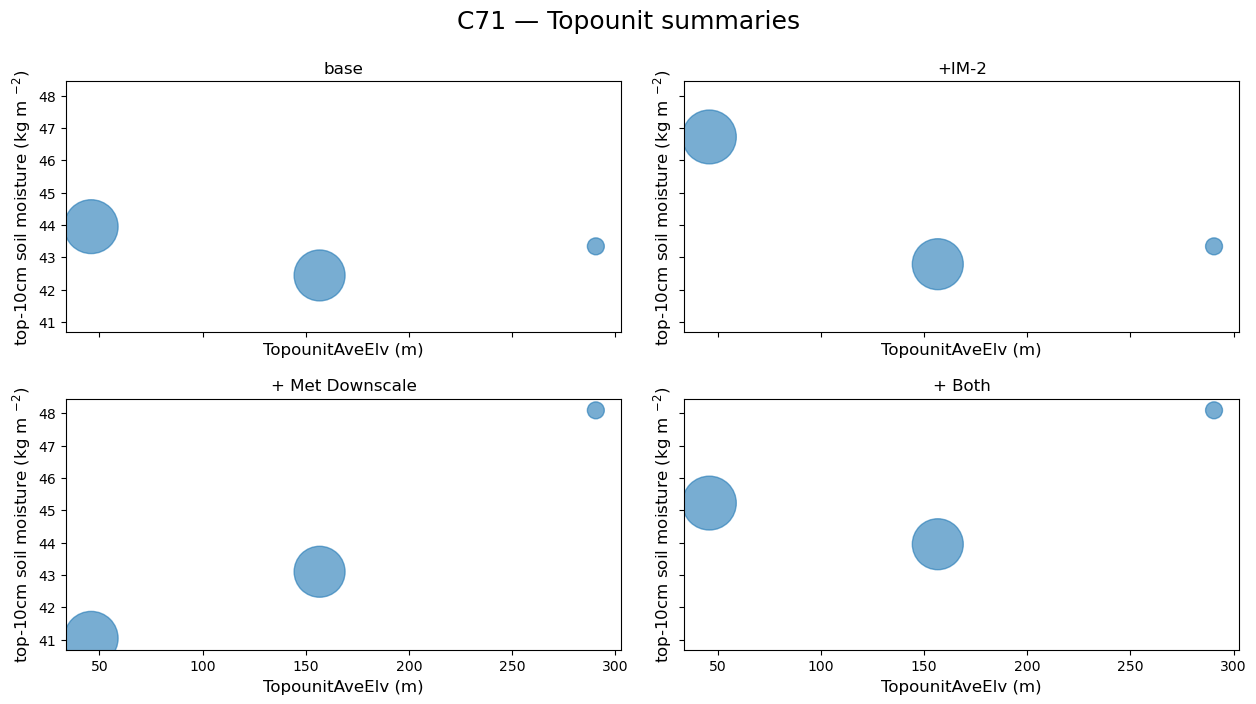

In [8]:
#%% notebook block 1: show all the pieces in topounit aggregateion-- these can be cells in a notebook

#Cell 1: define an indivual case and site
case_key = "IM1_DS1"
site_acronym = "C71"
varname = "SOILWATER_10CM"

# Cell 2: get history file for case
cur_ds_hist = get_and_aggregate_hist_ds(case_key) 
cur_ds_hist

# Cell 3: get gridcell containing site, and the subgrid units
df_subgrid_units, cell = get_active_subgrid_units_df(cur_ds_hist,site_acronym, varname)
df_subgrid_units

# Cell 4: aggregate variable to topo unit level
df_topo_aggregated = aggregate_subgrid_df_to_topounit(df_subgrid_units, varname)
df_topo_aggregated

# Cell 5: get topo metadata from surface file
df_topounit_metadata_from_surf = get_surface_topo_df_for_cell(
    grid_lat=cell["grid_lat"],
    grid_lon=cell["grid_lon"]
)
df_topounit_metadata_from_surf 

# Cell 6: join the two parts
joined_df = join_topo_metadata_from_surface_file(df_topo_aggregated, df_topounit_metadata_from_surf, decimal_places=4)
joined_df

# Cell 7: 4 panel plot, per site

# plot 4 panel, one site
four_case_dict = compute_all_cases_per_site(varname,site_acronym)
plot_four_cases(four_case_dict,varname,site_acronym)

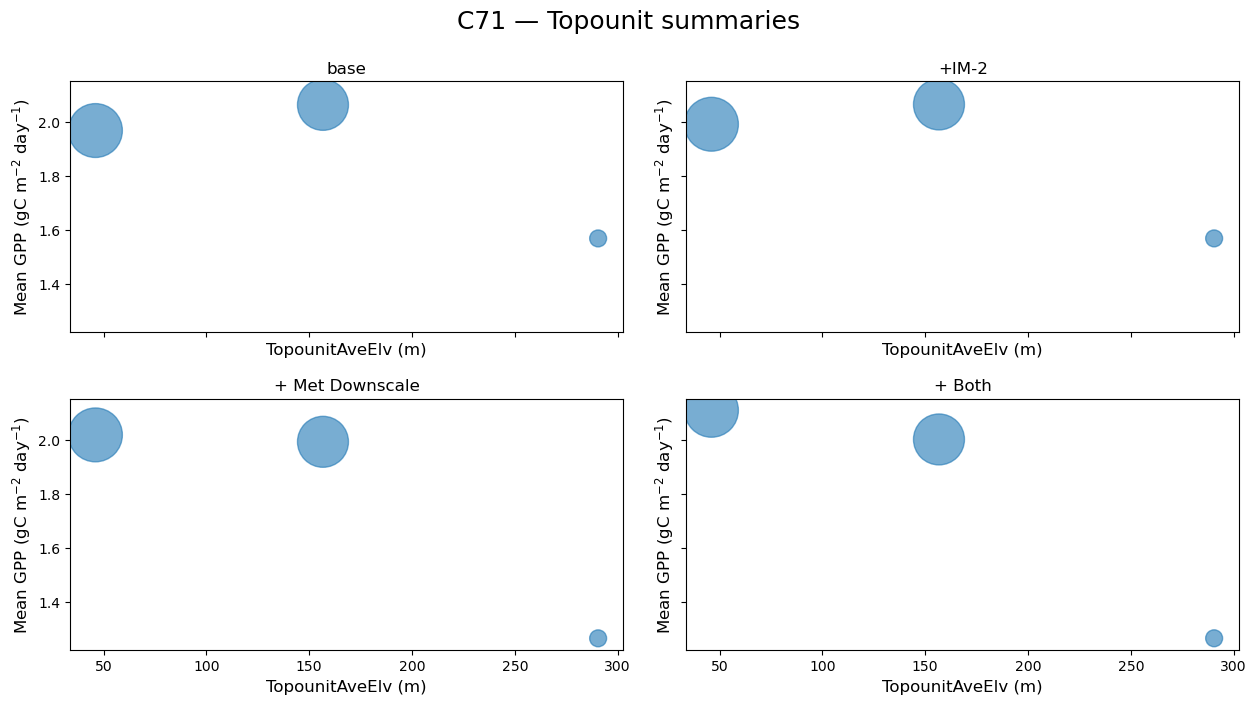

In [9]:
#%% notebook block 2: show all the pieces in topounit aggregateion-- these can be cells in a notebook

#Cell 1: define an indivual case and site
case_key = "IM1_DS1"
site_acronym = "C71"
varname = "GPP"

# Cell 2: get history file for case
cur_ds_hist = get_and_aggregate_hist_ds(case_key) 
cur_ds_hist

# Cell 3: get gridcell containing site, and the subgrid units
df_subgrid_units, cell = get_active_subgrid_units_df(cur_ds_hist,site_acronym, varname)
df_subgrid_units

# Cell 4: aggregate variable to topo unit level
df_topo_aggregated = aggregate_subgrid_df_to_topounit(df_subgrid_units, varname)
df_topo_aggregated

# Cell 5: get topo metadata from surface file
df_topounit_metadata_from_surf = get_surface_topo_df_for_cell(
    grid_lat=cell["grid_lat"],
    grid_lon=cell["grid_lon"]
)
df_topounit_metadata_from_surf 

# Cell 6: join the two parts
joined_df = join_topo_metadata_from_surface_file(df_topo_aggregated, df_topounit_metadata_from_surf, decimal_places=4)
joined_df

# Cell 7: 4 panel plot, per site

# plot 4 panel, one site
four_case_dict = compute_all_cases_per_site(varname,site_acronym)
plot_four_cases(four_case_dict,varname,site_acronym)